In [223]:
from pychoropleth import choropleth, create_grid, add_cell_id, bounds_to_polygon
import pandas as pd
import numpy as np
import random
import geopandas
from matplotlib import pyplot as plt
from tqdm import tqdm
from glob import glob
import os
import osmnx as ox
import mplleaflet
import subprocess

In [224]:
# 0 lyft
# 1 spin
# 2 link

In [311]:
from pyproj import CRS
crs_4326 = CRS("WGS84")
grid_size=100

bounds = bounds_to_polygon([-117.30, 32.65,-117.05, 32.90])
# bounds = bounds_to_polygon([-117.16995268721358, 32.709196060473545, -117.1176425083909, 32.73550987502212])

In [312]:
last = "data/clean/2021-01-01.tar.gz"

In [313]:
todo = []
for file in tqdm(sorted(glob("data/clean/*.tar.gz"))):
    todo.append(file)

100%|██████████| 21/21 [00:00<00:00, 18194.67it/s]


In [314]:
todo

['data/clean/2022-03-02.tar.gz',
 'data/clean/2022-03-03.tar.gz',
 'data/clean/2022-03-04.tar.gz',
 'data/clean/2022-03-05.tar.gz',
 'data/clean/2022-03-06.tar.gz',
 'data/clean/2022-03-07.tar.gz',
 'data/clean/2022-03-08.tar.gz',
 'data/clean/2022-03-09.tar.gz',
 'data/clean/2022-03-10.tar.gz',
 'data/clean/2022-03-11.tar.gz',
 'data/clean/2022-03-12.tar.gz',
 'data/clean/2022-03-13.tar.gz',
 'data/clean/2022-03-14.tar.gz',
 'data/clean/2022-03-15.tar.gz',
 'data/clean/2022-03-16.tar.gz',
 'data/clean/2022-03-17.tar.gz',
 'data/clean/2022-03-18.tar.gz',
 'data/clean/2022-03-19.tar.gz',
 'data/clean/2022-03-20.tar.gz',
 'data/clean/2022-03-21.tar.gz',
 'data/clean/2022-03-22.tar.gz']

In [315]:
some_clean = {0:[], 1:[], 2:[], "all":[]}
for f in (sorted(todo))[-3:]:
    a_clean = pd.read_csv(f)
    a_clean.timestamp = pd.to_datetime(a_clean.timestamp, utc=True)
    a_clean = a_clean.set_index("timestamp")
    a_clean = a_clean[a_clean.is_disabled == 0]
    if len(a_clean) > 0:
        a_clean = a_clean[["bike_id","lat","lon", "provider"]]
        a_clean = a_clean.tz_convert("US/Pacific")
        all_p = []
        for i, ddf in tqdm(a_clean.groupby(pd.Grouper(freq="300S", sort=True, origin="epoch"))):
            section = ddf.drop_duplicates(subset=["bike_id"])
            _, cmdf = add_cell_id(section, grid_size, bounds=bounds, latitude="lat", longitude="lon", crs=crs_4326)
            for prov, xcmdf in cmdf.groupby("provider"):
                x =  xcmdf.groupby("cell_id").count()[["bike_id"]]
                x.columns = [i]
                some_clean[prov].append(x)
            x =  cmdf.groupby("cell_id").count()[["bike_id"]]
            x.columns = [i]
            some_clean["all"].append(x)
            
    break

100%|██████████| 288/288 [10:07<00:00,  2.11s/it]


In [167]:
try:
    joined = pd.read_csv("data/aggregated/agg1.csv").set_index("Unnamed: 0")
    joined.index = pd.to_datetime(joined.index)
    joined.columns = [eval(x) for x in joined.columns]
    joined = joined.T
except:
    joined = None

In [304]:
joined = None
for x in some_clean[2]:
    if joined is None:
        joined = x
    else:
        if x.columns[0] not in joined.columns:
            joined = joined.join(x, how="outer")
        else:
            print("what?")
x = joined.fillna(0).T.sort_index()

In [305]:
# if "data/aggregated/agg1.csv" already exists...
# joined.fillna(0).T.sort_index().to_csv("data/aggregated/agg.csv")

In [306]:
# read aggregated data
# x = pd.read_csv("data/aggregated/agg.csv").set_index("Unnamed: 0")
# x.index = pd.to_datetime(x.index)
# x.columns = [eval(x) for x in x.columns]

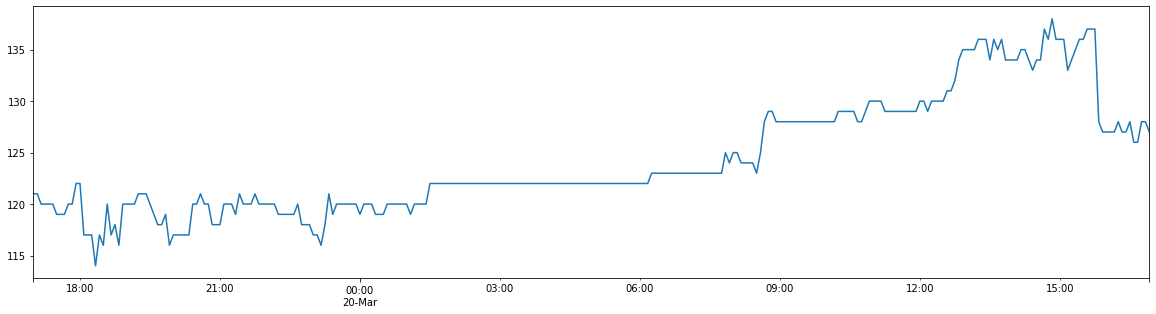

In [307]:
# all available scooters
ax = x.T.sum().T.plot(figsize=[20,5])

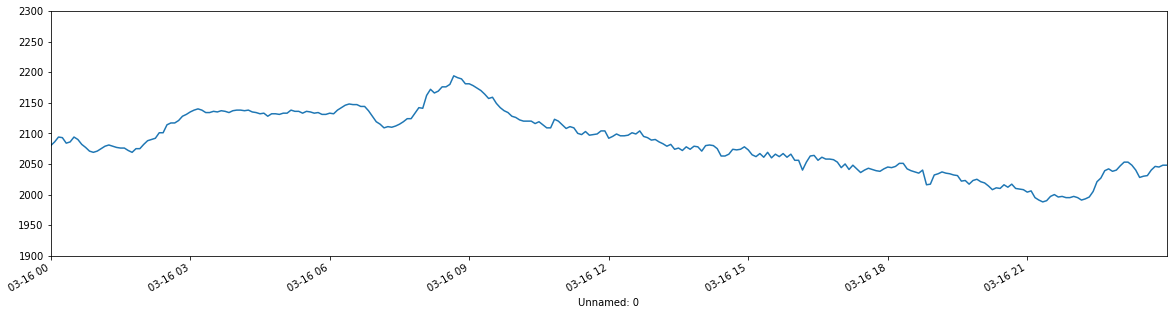

In [63]:
ax = x.T.sum().T.plot(figsize=[20,5])
ax.set_xlim(["2022-03-16 00:00:00-08:00","2022-03-16 23:59:59-08:00"])
_ = ax.set_ylim([1900, 2300])

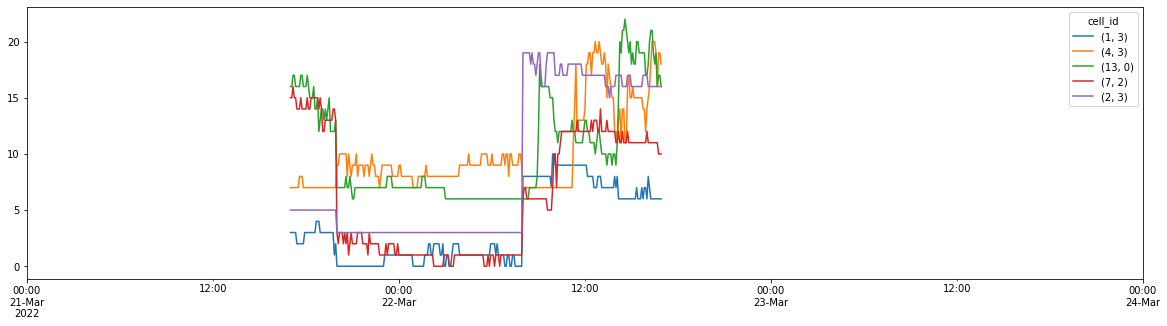

In [33]:
# some interesting cells
mstd = x.std().sort_values()[-5:]
ax = x[mstd.index.values].plot(figsize=[20,5])
_ = ax.set_xlim(["2022-03-21","2022-03-24"])

In [43]:
# read weather data
w = []
for i in glob("data/worldweatheronline/*"):
    wx = pd.read_csv(i).dropna()
    wx["Timestamp"] = pd.to_datetime(wx["Timestamp"])
    w.append(wx.set_index("Timestamp"))
w=pd.concat(w).sort_index()
w.head()

,tempC,windspeedKmph,weatherDesc,FeelsLikeC,uvIndex,precipMM,humidity,visibility,pressure,date,hour
Timestamp,,,,,,,,,,,
2021-01-01 00:00:00-08:00,10,3,Clear,10,1,0.0,58,10,1015,2021-01-01,0 days 00:00:00
2021-01-01 01:00:00-08:00,12,4,Clear,12,1,0.0,55,10,1015,2021-01-01,0 days 01:00:00
2021-01-01 02:00:00-08:00,14,5,Partly cloudy,14,1,0.0,52,10,1015,2021-01-01,0 days 02:00:00
2021-01-01 03:00:00-08:00,16,6,Partly cloudy,16,1,0.0,48,10,1015,2021-01-01,0 days 03:00:00
2021-01-01 04:00:00-08:00,16,5,Partly cloudy,16,1,0.0,45,10,1015,2021-01-01,0 days 04:00:00


In [44]:
# print cell location

In [65]:
def cell_to_geometry(cell, bounds=bounds, grid_size=grid_size):
    pbounds = ox.projection.project_geometry(bounds)
    min_x = pbounds[0].bounds[0] + cell[0]*grid_size
    min_y = pbounds[0].bounds[1] + cell[1]*grid_size
    max_x = min_x + grid_size
    max_y = min_y + grid_size
    points = bounds_to_polygon([min_x,min_y,max_x,max_y])
    polygon1 = ox.projection.project_geometry(points, crs=pbounds[1], to_latlong=True)[0]
    x,y = polygon1.exterior.xy
    plt.figure(figsize=[5,5])
    plt.plot(x,y)
    return mplleaflet.display()

def print_cell_day(cell, day):
    ss = x[cell]
    ax = w.precipMM.plot(figsize=[20,10])
    w.tempC.plot(ax=ax)
    w.windspeedKmph.plot(ax=ax)
    w.uvIndex.plot(ax=ax)

    ss.plot(figsize=[20, 5], ax=ax)
    ax.set_xlim([f"{day} 00:00:00-08:00",f"{day} 23:59:59-08:00"])
    ax.set_ylim([0,40])
    _ = plt.legend()

In [140]:
cell_to_geometry((233, 278))

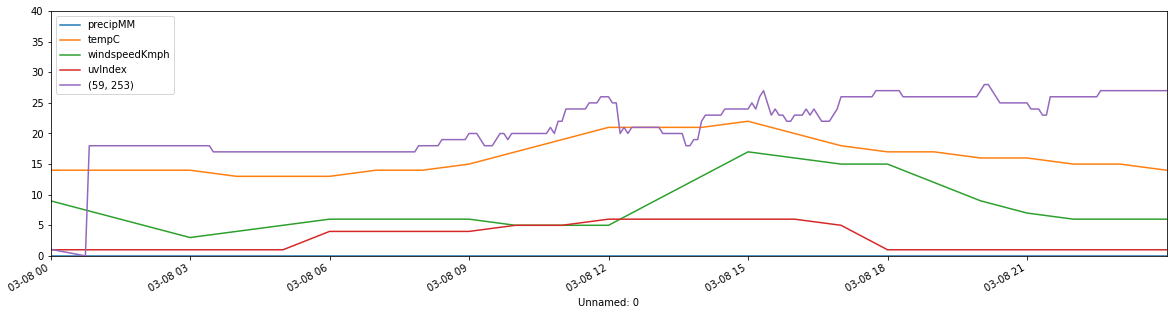

In [51]:
print_cell_day((59, 253), "2022-03-08")

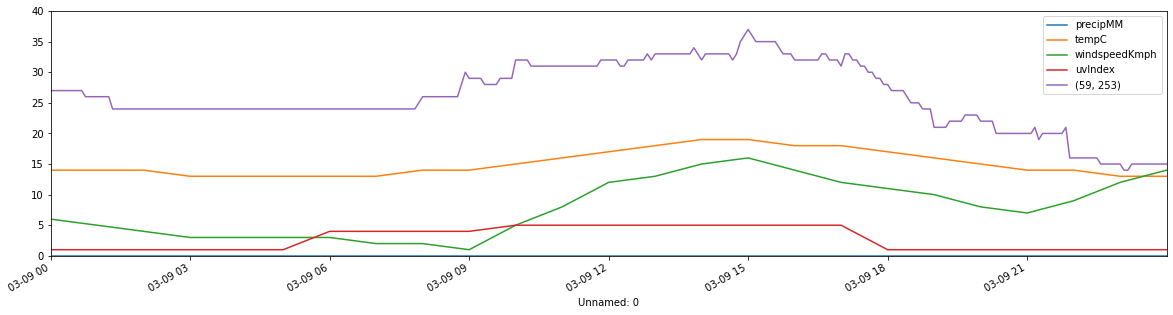

In [52]:
print_cell_day((59, 253), "2022-03-09")

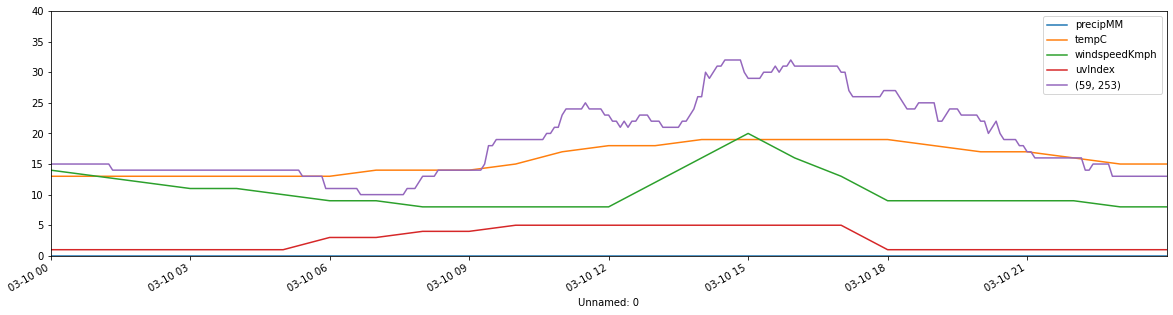

In [53]:
print_cell_day((59, 253), "2022-03-10")

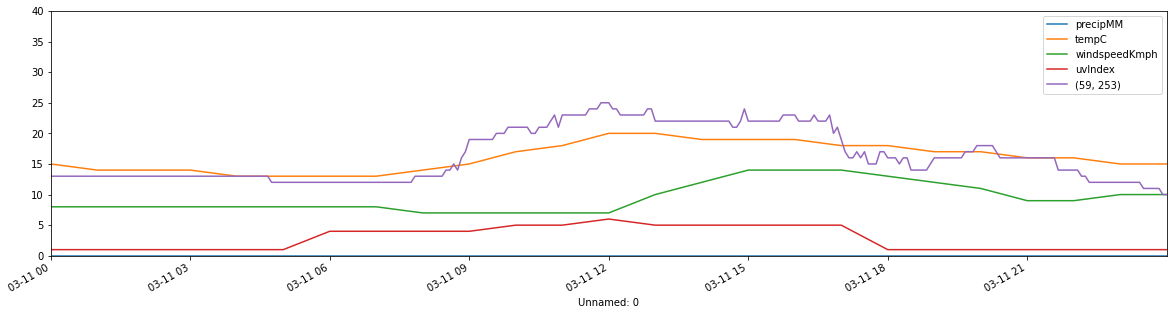

In [54]:
print_cell_day((59, 253), "2022-03-11")

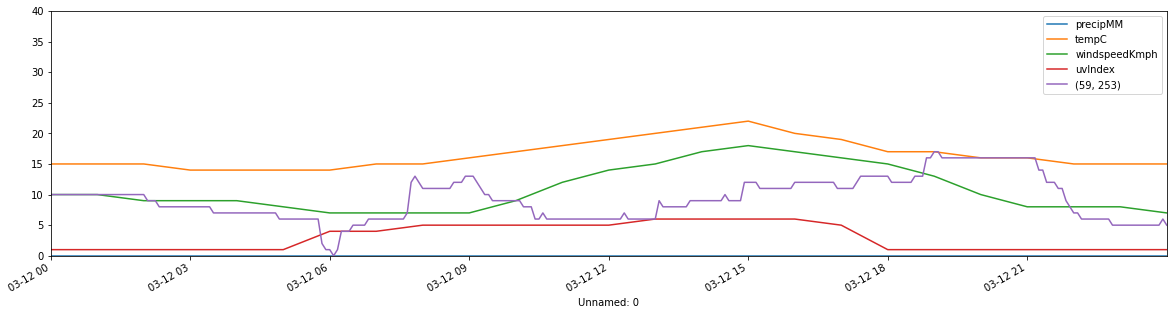

In [55]:
print_cell_day((59, 253), "2022-03-12")

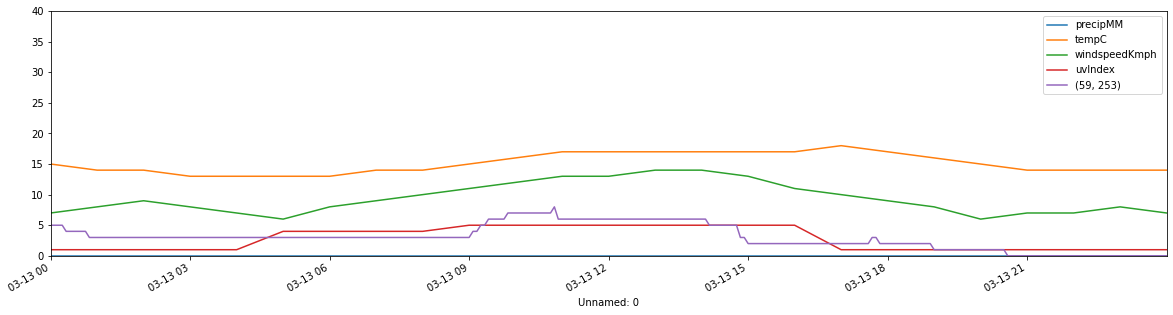

In [56]:
print_cell_day((59, 253), "2022-03-13")

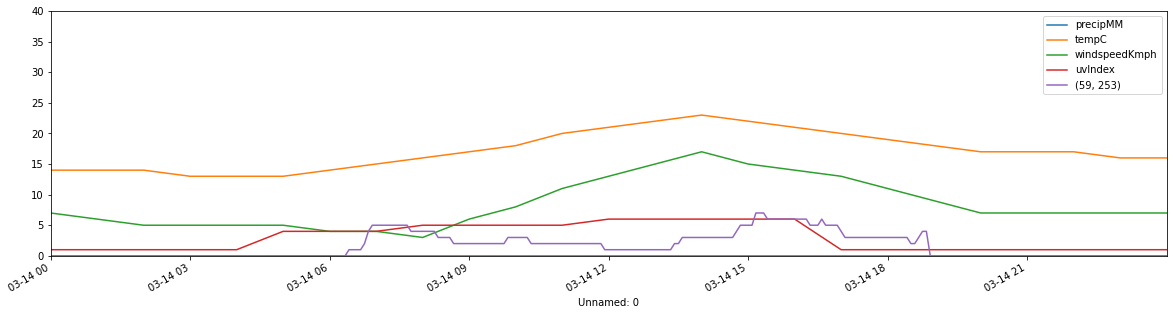

In [57]:
print_cell_day((59, 253), "2022-03-14")

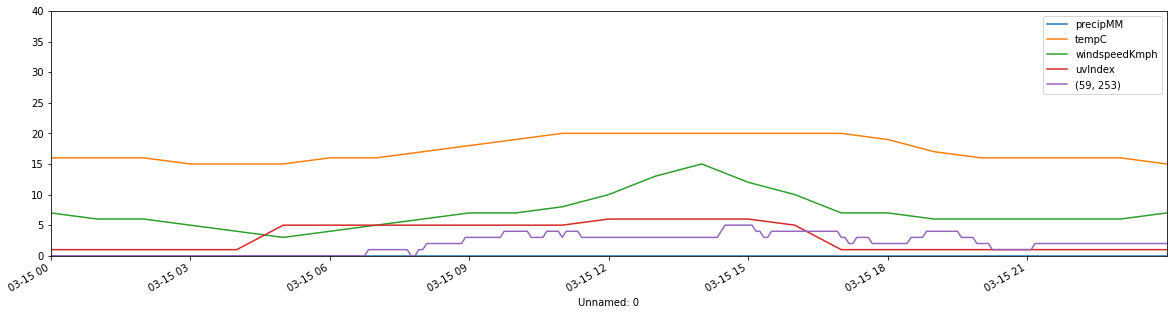

In [58]:
print_cell_day((59, 253), "2022-03-15")

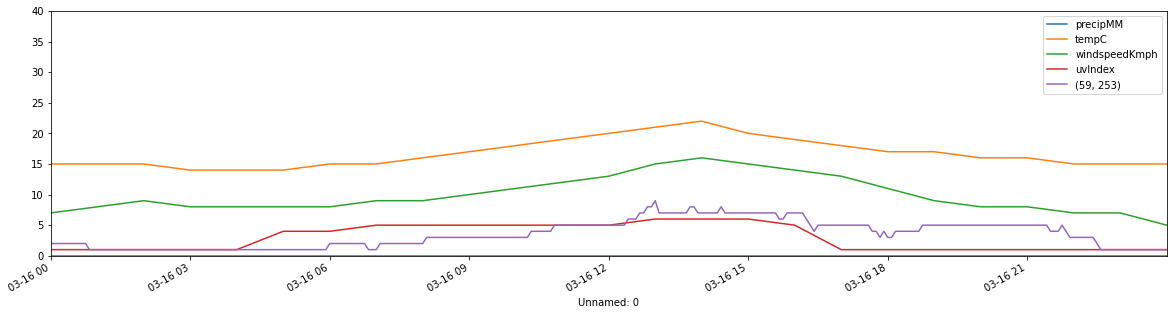

In [59]:
print_cell_day((59, 253), "2022-03-16")

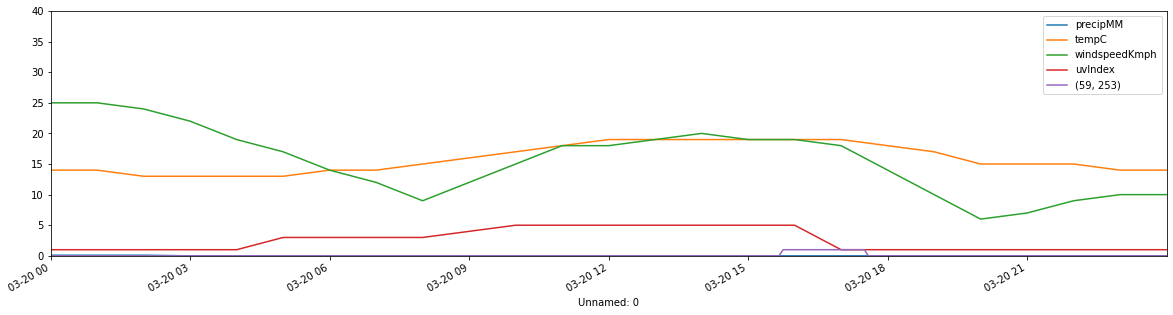

In [66]:
print_cell_day((59, 253), "2022-03-20")

In [99]:
pd.DataFrame([[c[0],c[1]] for c in x.T.index.values]).max()

0    46
1    29
dtype: int64

In [172]:
import numpy as np

def row_to_image(row):
    a = np.zeros([30,47])
    for i,r in row.iteritems():
        a[i[1],i[0]] = r
    return a

def generate_video(img):
    for i in tqdm(range(len(img))):
        plt.figure(figsize=[15,10])
        plt.imshow(img[i][1], cmap="Blues", origin='lower', vmin=0, vmax=15)
        plt.title(img[i][0])
        plt.savefig("data/video/file%05d.png" % i)
        plt.close()

    os.chdir("data/video/")
    subprocess.call([
        'ffmpeg', '-framerate', '8', '-i', 'file%05d.png', '-r', '30', '-pix_fmt', 'yuv420p',
        'video.mp4'
    ])
    for file_name in glob("*.png"):
        os.remove(file_name)
    os.chdir("../../")

In [173]:
all_images = []
for i in tqdm(range(0, len(x))):
    tmp = x.iloc[i]
    tmp = tmp[tmp>0]
    all_images.append([str(tmp.name), row_to_image(tmp)])

100%|██████████| 288/288 [00:00<00:00, 1204.15it/s]


In [107]:
generate_video(all_images)

100%|██████████| 288/288 [01:46<00:00,  2.71it/s]


In [208]:
transition = a_clean[(a_clean.index >= "2022-03-19 19:50") & (a_clean.index <= "2022-03-19 20:10")]

In [209]:
ddfs = []
for i, ddf in transition.groupby(pd.Grouper(freq="300S")):
    print(i)
    ddfs.append(ddf.drop_duplicates(subset=["bike_id"]))

2022-03-19 19:50:00-07:00
2022-03-19 19:55:00-07:00
2022-03-19 20:00:00-07:00
2022-03-19 20:05:00-07:00


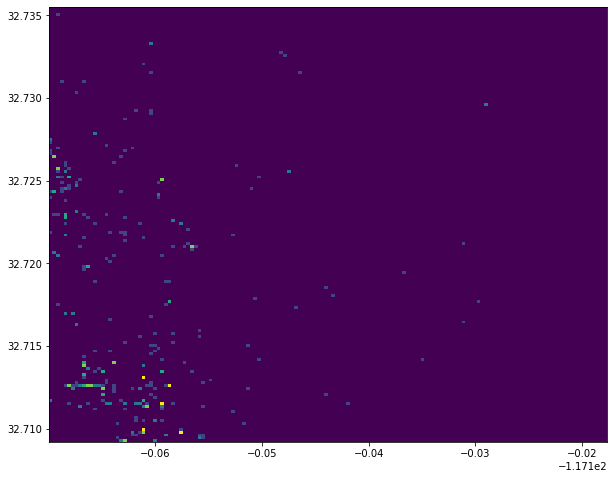

In [210]:
i = 1
plt.figure(figsize = (10,8))
plt.hist2d(ddfs[i].lon, ddfs[i].lat, bins=150, vmax=5, range=[[-117.16995268721358, -117.1176425083909], [32.709196060473545, 32.73550987502212]])
plt.show()

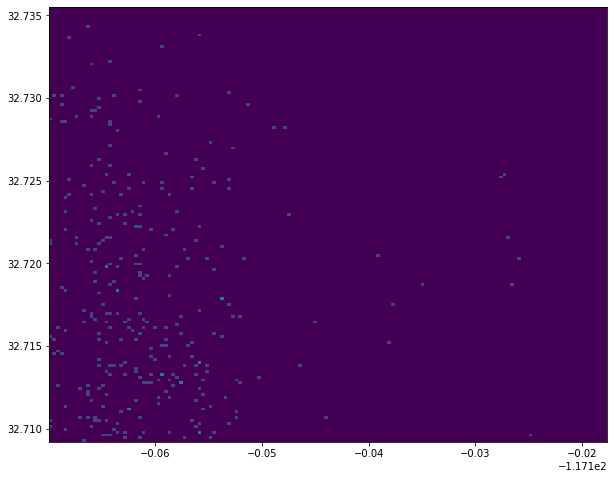

In [211]:
i = 2
plt.figure(figsize = (10,8))
plt.hist2d(ddfs[i].lon, ddfs[i].lat, bins=150, vmax=5, range=[[-117.16995268721358, -117.1176425083909], [32.709196060473545, 32.73550987502212]])
plt.show()

In [186]:
ddfs[1].set_index("bike_id").join(ddfs[2].set_index("bike_id"), lsuffix="l", how="outer")

,latl,lonl,lat,lon
bike_id,,,,
0043c7d7d05322e0e282e766d7f7a1cd,32.715976,-117.155904,NaN,NaN
00539123f868b5bc05debe988014a08f,NaN,NaN,32.709512,-117.161316
005ee240-1249-4782-a65c-7e1d25c27efd,32.752667,-117.248677,32.752667,-117.248677
0063a9c0-66e7-4a5e-9d2a-ebaedbdbdffb,32.752550,-117.251480,32.752550,-117.251480
007f7264-873f-45b1-9688-dca6e8c30539,32.489170,-116.876730,32.489170,-116.876730
...,...,...,...,...
ffad1039-fdd3-4f98-99c8-ebfb2628822f,32.535330,-117.047780,32.535330,-117.047780
ffd30688-59c1-45f1-9bf7-5401d066cbd3,32.755300,-117.100970,32.755300,-117.100970
ffd67719-8c97-49d8-9a94-c66a07352b51,32.869502,-117.214270,NaN,NaN


In [199]:
a_clean[a_clean.bike_id == "ffd67719-8c97-49d8-9a94-c66a07352b51"].values

array([['ffd67719-8c97-49d8-9a94-c66a07352b51', 32.869423, -117.2143],
       ['ffd67719-8c97-49d8-9a94-c66a07352b51', 32.869423, -117.2143],
       ['ffd67719-8c97-49d8-9a94-c66a07352b51', 32.869423, -117.2143],
       ['ffd67719-8c97-49d8-9a94-c66a07352b51', 32.869423, -117.2143],
       ['ffd67719-8c97-49d8-9a94-c66a07352b51', 32.869423, -117.2143],
       ['ffd67719-8c97-49d8-9a94-c66a07352b51', 32.869423, -117.2143],
       ['ffd67719-8c97-49d8-9a94-c66a07352b51', 32.869423, -117.2143],
       ['ffd67719-8c97-49d8-9a94-c66a07352b51', 32.869423, -117.2143],
       ['ffd67719-8c97-49d8-9a94-c66a07352b51', 32.869423, -117.2143],
       ['ffd67719-8c97-49d8-9a94-c66a07352b51', 32.869423, -117.2143],
       ['ffd67719-8c97-49d8-9a94-c66a07352b51', 32.869423, -117.2143],
       ['ffd67719-8c97-49d8-9a94-c66a07352b51', 32.869423, -117.2143],
       ['ffd67719-8c97-49d8-9a94-c66a07352b51', 32.869423, -117.2143],
       ['ffd67719-8c97-49d8-9a94-c66a07352b51', 32.869423, -117.2143],
      

In [197]:
a_clean[a_clean.bike_id == "00539123f868b5bc05debe988014a08f"].sort_index().values

array([['00539123f868b5bc05debe988014a08f', 32.709511593562304,
        -117.16131601634396],
       ['00539123f868b5bc05debe988014a08f', 32.709499760228965,
        -117.16134268296616],
       ['00539123f868b5bc05debe988014a08f', 32.70954826022897,
        -117.1612981831484],
       ['00539123f868b5bc05debe988014a08f', 32.70958709356232,
        -117.16135784996094],
       ['00539123f868b5bc05debe988014a08f', 32.70955759356232,
        -117.16148518318349]], dtype=object)

In [200]:
a_clean[(a_clean.lat == 32.869502000000004) & (a_clean.lon == -117.21427)]

,bike_id,lat,lon
timestamp,,,
2022-03-19 19:30:47-07:00,ffd67719-8c97-49d8-9a94-c66a07352b51,32.869502,-117.21427
2022-03-19 19:31:22-07:00,ffd67719-8c97-49d8-9a94-c66a07352b51,32.869502,-117.21427
2022-03-19 19:31:57-07:00,ffd67719-8c97-49d8-9a94-c66a07352b51,32.869502,-117.21427
2022-03-19 19:32:32-07:00,ffd67719-8c97-49d8-9a94-c66a07352b51,32.869502,-117.21427
2022-03-19 19:33:07-07:00,ffd67719-8c97-49d8-9a94-c66a07352b51,32.869502,-117.21427
2022-03-19 19:33:50-07:00,ffd67719-8c97-49d8-9a94-c66a07352b51,32.869502,-117.21427
2022-03-19 19:34:25-07:00,ffd67719-8c97-49d8-9a94-c66a07352b51,32.869502,-117.21427
2022-03-19 19:35:00-07:00,ffd67719-8c97-49d8-9a94-c66a07352b51,32.869502,-117.21427
2022-03-19 19:35:35-07:00,ffd67719-8c97-49d8-9a94-c66a07352b51,32.869502,-117.21427


In [308]:
check = x.diff().dropna().abs().T.sum()

In [309]:
check

2022-03-19 17:05:00-07:00    2.0
2022-03-19 17:10:00-07:00    1.0
2022-03-19 17:15:00-07:00    6.0
2022-03-19 17:20:00-07:00    4.0
2022-03-19 17:25:00-07:00    0.0
                            ... 
2022-03-20 16:35:00-07:00    4.0
2022-03-20 16:40:00-07:00    6.0
2022-03-20 16:45:00-07:00    8.0
2022-03-20 16:50:00-07:00    4.0
2022-03-20 16:55:00-07:00    3.0
Length: 287, dtype: float64

<AxesSubplot:>

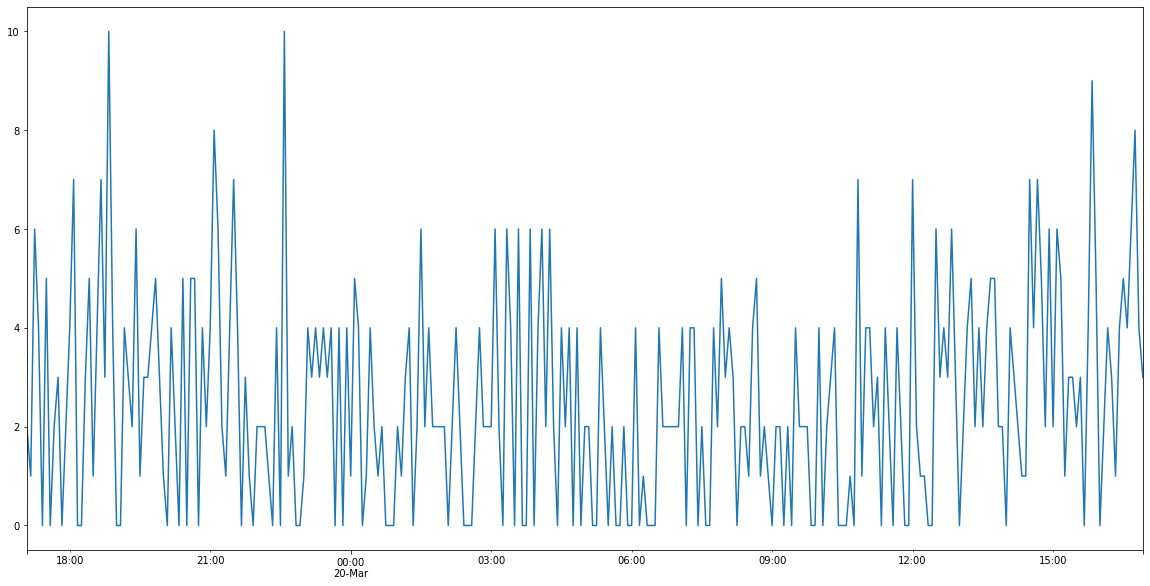

In [310]:
check.plot(figsize=[20,10])

In [257]:
test = a_clean[(a_clean.index >= "2022-03-21 19:45:00-07:00") & (a_clean.index <= "2022-03-21 20:15:00-07:00")]

In [259]:
groups = []
for i, ddf in test.groupby(pd.Grouper(freq="300S")):
    groups.append([i,ddf])

In [280]:
a = groups[2][1].drop_duplicates(subset=["bike_id"])
a = a.set_index("bike_id")

In [281]:
b = groups[3][1].drop_duplicates(subset=["bike_id"])
b = b.set_index("bike_id")

In [289]:
a.join(b, lsuffix="_")

,lat_,lon_,lat,lon
bike_id,,,,
6fddcc96-8d3e-49ab-8416-c545c8ed21d1,32.721120,-117.165640,32.721120,-117.165640
5e622f03-b5d6-40b7-bda1-da36ea0f4662,32.793790,-117.248840,32.793790,-117.248840
beff2b4d-b216-4759-884a-563c5d170aa5,32.747400,-117.250010,32.747400,-117.250010
80d4b11d-7210-4f56-aa0e-13c1ffb650cd,32.847640,-117.276130,32.847640,-117.276130
942f0078-5477-4914-890c-b8056c0a29f3,32.735030,-117.106430,32.735030,-117.106430
...,...,...,...,...
35ec0d1a-3b18-4f38-af73-b52d8b67230d,32.876000,-117.223415,32.876000,-117.223415
cf74ece9-27e5-40e5-9abc-3817b570f6ac,32.875985,-117.223415,32.875985,-117.223415
a92ef1c1-055f-4d84-9e3d-390154c9986b,32.888250,-117.242833,32.888250,-117.242833


In [14]:
x = joined.fillna(0)

<AxesSubplot:>

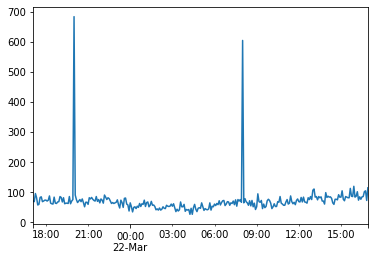

In [21]:
x.T.diff().dropna().abs().T.sum().plot()

In [19]:
x.T

cell_id,"(18, 212)","(20, 216)","(22, 219)","(23, 215)","(23, 217)","(23, 219)","(24, 210)","(24, 212)","(24, 214)","(24, 215)",...,"(189, 116)","(189, 117)","(190, 117)","(191, 117)","(192, 117)","(194, 117)","(201, 108)","(205, 118)","(229, 21)","(232, 25)"
2022-03-21 17:00:00-07:00,0.0,1.0,6.0,1.0,2.0,0.0,4.0,3.0,6.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2022-03-21 17:05:00-07:00,0.0,1.0,6.0,1.0,1.0,0.0,4.0,3.0,6.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2022-03-21 17:10:00-07:00,0.0,1.0,6.0,1.0,1.0,0.0,4.0,3.0,6.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2022-03-21 17:15:00-07:00,0.0,1.0,6.0,1.0,1.0,0.0,4.0,3.0,6.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2022-03-21 17:20:00-07:00,0.0,1.0,6.0,1.0,1.0,0.0,4.0,3.0,6.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-22 16:35:00-07:00,1.0,0.0,3.0,1.0,3.0,1.0,1.0,3.0,6.0,0.0,...,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0
2022-03-22 16:40:00-07:00,1.0,0.0,3.0,1.0,3.0,1.0,1.0,3.0,6.0,0.0,...,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0
2022-03-22 16:45:00-07:00,1.0,0.0,3.0,1.0,3.0,1.0,1.0,3.0,6.0,0.0,...,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0
2022-03-22 16:50:00-07:00,1.0,0.0,3.0,1.0,3.0,1.0,1.0,3.0,6.0,0.0,...,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0


In [212]:
# data2

In [219]:
pd.read_csv("data2/data/spin san_diego_2022-03-23 23:59:32.csv.tar.gz")

,Unnamed: 0,bike_id,lat,lon,is_reserved,is_disabled,rental_uris,vehicle_type_id,current_range_meters,last_reported,pricing_plan_id
0,0,87d7f30a-d815-4eeb-91e8-4469cd43edef,32.798978,-117.254308,False,False,{'android': 'https://spin.onelink.me/e2Wc?pid=...,1,11280,1648079769,san_diego_scooter_plan
1,1,adb5bc1a-42b2-4b53-99fe-4eecca4e06d9,32.882225,-117.219915,False,False,{'android': 'https://spin.onelink.me/e2Wc?pid=...,1,19440,1648079929,san_diego_scooter_plan
2,2,cb4695ce-0214-439b-8e05-c87afac8b0e5,32.711390,-117.156730,False,False,{'android': 'https://spin.onelink.me/e2Wc?pid=...,1,8160,1648079894,san_diego_scooter_plan
3,3,01248b2a-d8d3-4b88-88d7-9a20e90912ef,32.712452,-117.168220,False,False,{'android': 'https://spin.onelink.me/e2Wc?pid=...,1,18240,1648079960,san_diego_scooter_plan
4,4,753bff91-b963-42e5-9010-dcb24f023122,32.883710,-117.244072,False,False,{'android': 'https://spin.onelink.me/e2Wc?pid=...,2,28320,1648079941,san_diego_ebike_plan
...,...,...,...,...,...,...,...,...,...,...,...
704,704,ddd53852-68ee-47da-8d51-b2320e098178,32.772422,-117.252700,False,False,{'android': 'https://spin.onelink.me/e2Wc?pid=...,1,12480,1648079811,san_diego_scooter_plan
705,705,e66d086f-f018-412d-87d4-d1aef9ad29e4,32.748378,-117.154941,False,False,{'android': 'https://spin.onelink.me/e2Wc?pid=...,1,13440,1648079855,san_diego_scooter_plan
706,706,121eea25-9158-424e-9321-baf821bc30bc,32.732147,-117.146620,False,False,{'android': 'https://spin.onelink.me/e2Wc?pid=...,1,10320,1648079679,san_diego_scooter_plan
707,707,0c1fa442-e5d4-4d58-bc0a-0f0a7be3f3cf,32.708962,-117.150491,False,False,{'android': 'https://spin.onelink.me/e2Wc?pid=...,1,20160,1648079934,san_diego_scooter_plan


In [221]:
pd.read_csv("data2/data/spin san_diego_2022-03-24 00:00:07.csv.tar.gz")

,Unnamed: 0,bike_id,lat,lon,is_reserved,is_disabled,rental_uris,vehicle_type_id,current_range_meters,last_reported,pricing_plan_id
0,0,87d7f30a-d815-4eeb-91e8-4469cd43edef,32.798978,-117.254308,False,False,{'android': 'https://spin.onelink.me/e2Wc?pid=...,1,11280,1648079769,san_diego_scooter_plan
1,1,adb5bc1a-42b2-4b53-99fe-4eecca4e06d9,32.882225,-117.219915,False,False,{'android': 'https://spin.onelink.me/e2Wc?pid=...,1,19440,1648079989,san_diego_scooter_plan
2,2,cb4695ce-0214-439b-8e05-c87afac8b0e5,32.711390,-117.156730,False,False,{'android': 'https://spin.onelink.me/e2Wc?pid=...,1,8160,1648079894,san_diego_scooter_plan
3,3,01248b2a-d8d3-4b88-88d7-9a20e90912ef,32.712452,-117.168220,False,False,{'android': 'https://spin.onelink.me/e2Wc?pid=...,1,18240,1648079960,san_diego_scooter_plan
4,4,753bff91-b963-42e5-9010-dcb24f023122,32.883710,-117.244072,False,False,{'android': 'https://spin.onelink.me/e2Wc?pid=...,2,28320,1648080002,san_diego_ebike_plan
...,...,...,...,...,...,...,...,...,...,...,...
700,700,ddd53852-68ee-47da-8d51-b2320e098178,32.772422,-117.252700,False,False,{'android': 'https://spin.onelink.me/e2Wc?pid=...,1,12480,1648079811,san_diego_scooter_plan
701,701,e66d086f-f018-412d-87d4-d1aef9ad29e4,32.748378,-117.154941,False,False,{'android': 'https://spin.onelink.me/e2Wc?pid=...,1,13440,1648079855,san_diego_scooter_plan
702,702,121eea25-9158-424e-9321-baf821bc30bc,32.732147,-117.146620,False,False,{'android': 'https://spin.onelink.me/e2Wc?pid=...,1,10320,1648080004,san_diego_scooter_plan
703,703,0c1fa442-e5d4-4d58-bc0a-0f0a7be3f3cf,32.708962,-117.150491,False,False,{'android': 'https://spin.onelink.me/e2Wc?pid=...,1,20160,1648079934,san_diego_scooter_plan
